# Making allele frequency plots

This notebook contains code to process the CRISPResso "allele frequency table" files from base editor validation experiments. The inputs are 2 input files: the first contains metainformation about each sample to make the "allele frequency" file, and the second contains metainformation to compute correlations between the log-normalized read counts. The output of this file are 3 files for each sgRNA / primer pair: 
1. a file containing all alleles and their read counts for each sample
2. a filtered version of (1) that only contains alleles with at least 1% abundance in any sample
3. a file containing the Pearson correlations between log-normalized read counts of each allele with > 100 reads in at least one sample

(1) is the starting file used to show the abundance of specific edits over time (code in BEV_aa_over_time.ipynb). (2) is the starting file used to create allele-level heatmaps (this was done using GraphPad Prism). (3) is the starting file for the plots showing the replicate correlation for validation experiments (actual plots were made using GraphPad Prism).

In [120]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
from IPython.display import HTML
import random

def hide_toggle(toggle_text_addon = '', for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'
    
    toggle_text = 'Show/Hide' + ' ' + toggle_text_addon  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle(toggle_text_addon='Toggle Function')

In [122]:
import sys
sys.path.append('../scripts/')
import pandas as pd 
import numpy as np 
import core_functions as cfs
from math import log
import os
from os import path
import itertools
import re
from pathlib import Path
from tqdm import tqdm

pd.set_option('display.max_colwidth', None)

In [5]:
print('Python version: ' + sys.version)

Python version: 3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [6]:
modules = ['pandas', 'numpy']
for module in modules:
    try:
        print(module + ' ' + sys.modules[module].__version__)
    except:
        print(module + ' has no __version__ attribute')

pandas 1.2.1
numpy 1.19.5


## Functions

In [7]:
'''
This function removes any NaN rows from input_file

INPUTS
------
df: metainformation file data frame

OUTPUTS
-------
df: metainformation file data frame with any empty/NaN rows removed

'''
def clean_input_file(df):
    if True in df.isnull().all(1).to_list():
        for i, row in df.iterrows():
            if row.isnull().all:
                print(row)
                df = df.drop(row, axis = 1)
        df = df.dropna() #drop NaN
        if 'BEV_start' in df.columns:
            df = df.drop('BEV_start', axis=1)
        if 'BEV_end' in df.columns:
            df = df.drop('BEV_end', axis=1)
        #dropna() converts int to float, so convert them back
        float_cols = df.select_dtypes(include=['float64']).columns #select subset of df of type float
        for col in float_cols:
            #get original column index so can replace at correct loc
            index = df.columns.get_loc(col)
            #rename float cols as "float_"col name
            float_col_name = 'float_' + col
            df = df.rename(columns = {col : float_col_name})
            #overwrite as type int
            float_to_int = df[float_col_name].astype(int).copy()
            df.insert(index, col, float_to_int)
            #drop float column
            df = df.drop(float_col_name, axis = 1)
    return df
hide_toggle(toggle_text_addon='clean_input_file function')

In [38]:
'''
Called from: process_data_v2
Function: removes UTRs from Aligned_Sequence before translation

INPUTS
------
translation_ref_seq: reference sequence from input file with intron sequence indicated by lowercase 
aligned: Aligned_sequence from merge df 
rev_com: True (from input file) if sequence needs to be reverse complemented 

OUTPUTS
-------
new_aligned: aligned sequence without UTRs and reverse complemented if necessary 

'''
def remove_utr(translation_ref_seq, aligned, rev_com):
    if ('[' not in translation_ref_seq) and (']' not in translation_ref_seq): # if no UTR
        return
    intron_flag = False # default value for intron flag is False
    if any(char for char in translation_ref_seq if char.islower()): # check for any introns
        intron_flag = True
        translation_ref_seq = translation_ref_seq.upper()
    
    # check if number of open brackets equals number of closed brackets
    if translation_ref_seq.count('[') != translation_ref_seq.count(']'):
        print('Unequal number of open and closed brackets. Please make sure all brackets are closed.')
        return
    open_bracket = False # True when encounters open bracket [
    closing_bracket = False # True when encounters closed bracket ]
    in_utr = False # True when open_bracket == True and closing_bracket == False
    utr_list = []
    utr = ''
    utr_start_end_list = []
    start_end = [] 
    bracket_count = 0
    # check to make sure all open brackets are only followed by closed, and closed is never followed by closed
    for idx, char in enumerate(translation_ref_seq):
        if char == '[':
            if open_bracket: # if already encountered open bracket
                print('Open bracket encountered after open bracket. Please make sure all brackets are closed.')
                return
            else:
                open_bracket = True
                closing_bracket = False
                
        if char == ']':
            if open_bracket: # if this ] closes encountered open bracket
                open_bracket = False
                closing_bracket = True
                bracket_count +=1 # count closed bracket 
                in_utr = False # end of UTR
                utr_list.append(utr) # add UTR sequence to list

                start_end.append(start_end[0]+len(utr)- 1)

                utr_start_end_list.append(start_end)
                utr = '' # Reset UTR
                start_end = [] # Rest start_end index pair
                
            elif closing_bracket: # if already encountered closing bracket
                print('Closing bracket encountered after closing bracket. Please check input.')
                return
            else:
                print('No open bracket encountered. Please check input.')
                return
        
        if (open_bracket and not closing_bracket) and (char != '[') and (char != ']'):
            in_utr = True 
            # if first character in utr, store start index
            if len(utr) == 0:
                bracket_count +=1 # count open bracket
                start_end.append(idx-bracket_count) # subtract # brackets encountered
            utr = utr + char
    
    new_aligned = aligned 
    new_aligned_list = []
    new_utrs = []
    new_utr_start_end_list = []
    # get length of translation_ref_seq without brackets
    len_translation_ref_seq = len(translation_ref_seq.replace('[','').replace(']',''))
    
    if rev_com: # need to reverse complement UTR from translation_ref_seq to match aligned seq
        # Reverse UTR index start, end positions if rev_com = True
        for num, i in enumerate(utr_start_end_list):
            start = i[0]
            end = i[1]

            new_idx_start = -(end+1) # reverse index, +1 b/c starts at -1 in reverse
        
            # convert to positive index by adding length of full translation_ref_seq (without brackets)
            new_idx_start = len_translation_ref_seq + new_idx_start

            new_idx_end = new_idx_start + len(utr_list[num]) - 1

            new_utr_start_end_list.append([new_idx_start, new_idx_end])
#       
        for utr in utr_list:
            rev_com_utr = cfs.revcom(utr)
            new_utrs.append(rev_com_utr)
    else:
        new_utr_start_end_list = utr_start_end_list
        new_utrs = utr_list
    
    if intron_flag: # if sequence contains both UTR(s) and intron(s)
        utr_df = pd.DataFrame()

        for i, start_end in enumerate(new_utr_start_end_list):
            utr_df.loc[i, 'start'] = int(start_end[0])
            utr_df.loc[i, 'end'] = int(start_end[1])
            utr_df.loc[i, 'sequence'] = new_utrs[i].upper()
            utr_df.loc[i, 'type'] = 'UTR'
            
        return utr_df
    
    else:
        len_prev_utr = 0
        for idx, utr in enumerate(new_utrs):
            # adjust start and end index based on length of prev UTR, because indices shift after removal of UTR
            # if first UTR, len_prev_utr = 0
            start_end_idx = new_utr_start_end_list[idx]

            if not rev_com: # if rev_com, UTRs removed in from end of sequence then upstream so earlier indices not affected
                start_end_idx = [start_end_idx[0]-len_prev_utr, start_end_idx[1]-len_prev_utr]

            # Check if bases at utr positions in aligned seq match utr
            new_aligned_utr = new_aligned[start_end_idx[0]:start_end_idx[1]+1]

            if new_aligned_utr != utr:
                if rev_com:
                    new_aligned_utr = cfs.revcom(new_aligned_utr)
                
                new_aligned_list.append(new_aligned_utr + ' (UTR)')

            # remove UTR based on index position 
            if start_end_idx[0] == 0: # if UTR at the beginning of new_aligned seq, keep substring after end_index
                new_aligned = new_aligned[start_end_idx[1]+1:]
            else: # (bases until start index + bases after end index)
                new_aligned = new_aligned[:start_end_idx[0]]+new_aligned[start_end_idx[1]+1:]

            len_prev_utr = len_prev_utr+len(utr) 

        if rev_com: # Now that UTR has been found, reverse complement again so correct translation input
            new_aligned = cfs.revcom(new_aligned)

        new_aligned_list.append(new_aligned)
        return new_aligned_list
    
hide_toggle(toggle_text_addon='remove_utr function')

In [39]:
from itertools import groupby
from operator import itemgetter
'''
Called from: process_data_v2
Function: removes introns from Aligned_Sequence before translation

INPUTS
------
translation_ref_seq: reference sequence from input file with intron sequence indicated by lowercase 
aligned: Aligned_sequence from merge df 
rev_com: True (from input file) if sequence needs to be reverse complemented 

OUTPUTS
-------
new_aligned: aligned sequence without introns and reverse complemented if necessary 

'''
from itertools import groupby
from operator import itemgetter

from itertools import groupby
from operator import itemgetter

def remove_introns(translation_ref_seq, aligned, rev_com):

    utr_flag = False # default value for utr_flag is False
    if ('[' in translation_ref_seq) or (']' in translation_ref_seq):
        utr_flag = True
        translation_ref_seq = translation_ref_seq.replace('[','').replace(']','')
        
    # get index positions of introns 
    intron_idx= [i for i, base in enumerate(translation_ref_seq) if base.islower()]

    intron_idx_list = []
    # Get consecutive indices to group indices for same intron
    for k, g in groupby(enumerate(intron_idx), lambda ix : ix[0] - ix[1]):
         intron_idx_list.append(list(map(itemgetter(1), g)))
    
    # if no introns, exit function
    if not intron_idx_list:

        return 
    
    # Get sequence of intron to check for intronic mutations 
    introns = []
    intron_start_end_list = []
    for intron_idx_group in intron_idx_list:
        intron_start = intron_idx_group[0]
        intron_end = intron_idx_group[-1]
        # store intron start and end index positions in pairs in list 
        intron_start_end_list.append([intron_idx_group[0], intron_idx_group[-1]])

        intron = translation_ref_seq[intron_start:intron_end+1]
        introns.append(intron)

    new_aligned = aligned.upper()
    new_aligned_list = []
    
    new_intron_start_end_list = []
    new_introns = []    

    if rev_com:
        # Reverse intron index positions if rev_com = True
        for i in intron_start_end_list:
            new_idx_start = -(i[1]+1) # reverse index
            # convert to positive index
            new_idx_start = len(translation_ref_seq) + new_idx_start
            new_idx_end = -(i[0]+1) # reverse index
            # convert to positive index
            new_idx_end = len(translation_ref_seq) + new_idx_end
            new_intron_start_end_list.append([new_idx_start, new_idx_end])

        for i in introns:
            rev_com_intron = cfs.revcom(i.upper())
            new_introns.append(rev_com_intron)

    else:
        new_intron_start_end_list = intron_start_end_list
        new_introns = introns
    
    if utr_flag: # if sequence contains both UTR(s) and introns(s), pass data to combo function
        intron_df = pd.DataFrame()

        for i, start_end in enumerate(new_intron_start_end_list):
            intron_df.loc[i, 'start'] = int(start_end[0])
            intron_df.loc[i, 'end'] = int(start_end[1])
            intron_df.loc[i, 'sequence'] = new_introns[i].upper()
            intron_df.loc[i, 'type'] = 'intron'
        return intron_df

    else:    

        len_prev_intron = 0
        for idx, intron in enumerate(new_introns):
            # if not first intron, adjust start and end index based on length of prev intron
            start_end_idx = new_intron_start_end_list[idx]
            if not rev_com:
                start_end_idx = [start_end_idx[0]-len_prev_intron, start_end_idx[1]-len_prev_intron]
            
            new_aligned_intron = new_aligned[start_end_idx[0]:start_end_idx[1]+1]
            
            # Check if bases at intron positions in aligned seq match intron
            if new_aligned_intron != intron.upper():
                if rev_com:
                    new_aligned_intron = cfs.revcom(new_aligned_intron)
                
                new_aligned_list.append(new_aligned_intron + ' (intron)')
#                 new_aligned_list.append('intron')


            # remove intron based on index position
            if start_end_idx[0] == 0: # if intron at the beginning of new_aligned seq, keep substring after end_index
                new_aligned = new_aligned[start_end_idx[1]+1:]

            else: # (bases until intron start index + bases after intron end index)
                new_aligned = new_aligned[:start_end_idx[0]]+new_aligned[start_end_idx[1]+1:]

            len_prev_intron = len_prev_intron + len(intron)

        if rev_com:
            new_aligned = cfs.revcom(new_aligned)

        new_aligned_list.append(new_aligned)
        return new_aligned_list

hide_toggle(toggle_text_addon='remove_introns function')

In [40]:
'''
Called from: process_data_v2
Function: removes introns and UTRs from Aligned_Sequence before translation if translation_ref_seq contains both

INPUTS
------
translation_ref_seq: reference sequence from input file with intron sequence indicated by lowercase 
aligned: Aligned_sequence from merge df 
rev_com: True (from input file) if sequence needs to be reverse complemented 

OUTPUTS
-------
new_aligned: aligned sequence without introns and UTRS and reverse complemented if necessary 

'''

def remove_utr_intron_combo(translation_ref_seq, aligned, rev_com):
#     print(translation_ref_seq.upper())
    utr_df = remove_utr(translation_ref_seq, aligned, rev_com)
    intron_df = remove_introns(translation_ref_seq, aligned, rev_com)
    
#     print(utr_df, intron_df)
    # Store UTR and intron start/end positions and sequences in single df
    removal_df = pd.concat([utr_df, intron_df]).sort_values(by='start').reset_index(drop=True)
    
    removal_df['start'] = removal_df['start'].copy().astype(int)
    removal_df['end'] = removal_df['end'].copy().astype(int)
    prev_start = 0
    prev_end = 0
    prev_type = ''
    
    new_aligned = aligned
    new_aligned_list = []
    len_prev_removal = 0
    
    for idx, removal_seq in enumerate(removal_df['sequence']):
        removal_row = removal_df.loc[idx, :]
        # if not first removal region (UTR/intron), adjust start and end index based on length of prev removal
        start_end_idx = [removal_row['start'], removal_row['end']]

        # Since start positions are ordered in ascending order, adjust based on length of prev removal 
        # regardless of rev_com

        start_end_idx = [start_end_idx[0]-len_prev_removal, start_end_idx[1]-len_prev_removal]
        
        new_aligned_to_remove = new_aligned[start_end_idx[0]:start_end_idx[1]+1]
        
        # Check if bases at removal positions in aligned seq match removal_seq
        if new_aligned_to_remove != removal_seq:
            if rev_com:
                new_aligned_to_remove = cfs.revcom(new_aligned_to_remove)
            if removal_row['type'] == 'UTR':
                new_aligned_list.append(new_aligned_to_remove + ' (UTR)')
#                 new_aligned_list.append('UTR')
            if removal_row['type'] == 'intron':
                new_aligned_list.append(new_aligned_to_remove + ' (intron)')
#                 new_aligned_list.append('intron')


        # remove region based on index position
        if start_end_idx[0] == 0: # if region at the beginning of new_aligned seq, keep substring after end_index
            new_aligned = new_aligned[start_end_idx[1]+1:]
        else: # (bases until intron start index + bases after intron end index)
            new_aligned = new_aligned[:start_end_idx[0]]+new_aligned[start_end_idx[1]+1:]
        len_prev_removal = len_prev_removal + len(removal_seq)

    if rev_com:
        new_aligned = cfs.revcom(new_aligned)
    new_aligned_list.append(new_aligned)
    return new_aligned_list


hide_toggle(toggle_text_addon='remove_utr_intron_combo Full Function')


In [41]:
'''
Called from: process_data_v2
Function: translates aligned sequence after removal of introns and/or UTRs

INPUTS
------
seq_list: list containing aligned sequence after removal of introns and/or UTRs 
as well as any edited intron and/or UTR regions (if applicable)
frame: frame for translation as described in metainformation file documentation
first_codon: first codon to be translated as described in metainformation file documentation
last_codon: last codon to be translated as described in metainformation file documentation
codon_map: dictionary mapping codon sequences to single letter amino acid annotation

OUTPUTS
-------
translation_list: list containing translated aligned sequence as well as "Possible intronic mutation" 
and/or "Possible UTR mutation" where applicable

'''

# This function returns the translation of a given sequence and frame
def translate(seq_list, frame, first_codon, last_codon, codon_map):
    if type(seq_list) is str: # if no UTRs or introns, convert sequence string to list
        seq_list = [seq_list]
        
    translation_list = []
    for seq in seq_list:
        if 'UTR' in seq:
            translation_list.append('Possible UTR mutation')
            continue
        if 'intron' in seq:
            translation_list.append('Possible intronic mutation')
            continue
        
        aa = ''
        i = 0
        # if frame is not 1, add nucleotides necessary to beginning of sequence for translation based on first_codon
        if frame == 2:
            seq = first_codon[0] + seq
            frame = 1
        if frame == 3:
            seq = first_codon[0:2] + seq
            frame = 1

        while i < len(seq):
            substring = ''
            while frame <= 3:
                if i<len(seq):
                    if seq[i] == '-': # deletion
                        i += 1
                        # frame doesn't change
                    else:
                        substring += seq[i]  
                        i += 1
                        frame+=1
                else: # if reached end of the sequence and frame still <=3, complete codon sequence based on last_codon
                    substring += last_codon[frame-1]
                    i += 1
                    frame+=1

            if len(substring) == 3:
                frame = 1 # reset frame 
                if ('N' in substring):
                    aa = aa + '-'
                else:
                    aa = aa + codon_map[substring] # translate codon
    #             print(aa)
            else:
                frame = 1
    #         print(frame)
    
        translation_list.append(aa)
#         return aa
    return translation_list

codon_map = {'TTT':'F', 'TTC':'F', 'TTA':'L', 'TTG':'L', 'CTT':'L', 'CTC':'L', 'CTA':'L', 'CTG':'L', 'ATT':'I', 'ATC':'I',
             'ATA':'I', 'ATG':'M', 'GTT':'V', 'GTC':'V', 'GTA':'V', 'GTG':'V', 'TCT':'S', 'TCC':'S', 'TCA':'S', 'TCG':'S',
             'CCT':'P', 'CCC':'P', 'CCA':'P', 'CCG':'P', 'ACT':'T', 'ACC':'T', 'ACA':'T', 'ACG':'T', 'GCT':'A', 'GCC':'A',
             'GCA':'A', 'GCG':'A', 'TAT':'Y', 'TAC':'Y', 'TAA':'*', 'TAG':'*', 'CAT':'H', 'CAC':'H', 'CAA':'Q', 'CAG':'Q',
             'AAT':'N', 'AAC':'N', 'AAA':'K', 'AAG':'K', 'GAT':'D', 'GAC':'D', 'GAA':'E', 'GAG':'E', 'TGT':'C', 'TGC':'C',
             'TGA':'*', 'TGG':'W', 'CGT':'R', 'CGC':'R', 'CGA':'R', 'CGG':'R', 'AGT':'S', 'AGC':'S', 'AGA':'R', 'AGG':'R',
             'GGT':'G', 'GGC':'G', 'GGA':'G', 'GGG':'G'}

hide_toggle(toggle_text_addon='translate function')

In [42]:
'''
Function: checks formatting and content of inputs for metainformation file and prints error messages if applicable

INPUTS
------
input_file: metainformation file

OUTPUTS
-------
"Input file is correct!" or "Please address errors listed above before proceeding."

'''

def check_input_file(input_file):
    
    print('Checking input file...')
    # Check each input column for correct formatting
    err_flag = False

    for i, row in tqdm(input_file.iterrows()):
        translation_err_flag = False
        utr_flag = False
        intron_flag = False
        sg = row['sg']
        # sgRNA sequence must be all uppercase
        sgRNA_seq = row['sgRNA_sequence'].upper()
        # translation_ref_seq: use WT aligned condition to check formatting, frame, first codon, last codon
        ref_seq = row['translation_ref_seq']

        # coding specific inputs
        frame = row['frame']
        first_codon = row['first_codon']
        last_codon = row['last_codon']
        rev_com = row['rev_com']

        # use frame = nan as indicator that guide targets non-coding region
        if np.isnan(frame):
            print('Guide targets non-coding region')
            if not np.isnan(first_codon):
                print('If guide targets non-coding region, please leave \'first_codon\' blank')
            if not np.isnan(last_codon):
                print('If guide targets non-coding region, please leave \'last_codon\' blank')
            if not np.isnan(rev_com):
                print('If guide targets non-coding region, please leave \'rev_com\' blank')

        else:
            # First and last codon must also be all uppercase (should be all coding)
            first_codon = row['first_codon'].upper()
            last_codon = row['last_codon'].upper()

            # Make sure there are only As, Cs, Gs, and Ts in the sequence inputs
            sequence_inputs = [sgRNA_seq, ref_seq, first_codon, last_codon]
            for seq in sequence_inputs:
                if seq: # if not empty
                    chars_allowed = ['A', 'C', 'G', 'T', '[', ']']
                    non_nuc_char = [char for char in seq if char.upper() not in chars_allowed]
                    if non_nuc_char: # if there are any characters that are not A, C, G, or T or brackets
                        print(non_nuc_char)
                        print('Invalid character in sequence. Please make sure the sequence only contains As, Cs, Gs, and Ts.')
                        return
                    else:
                        # Brackets only allowed in translation_ref_seq
                        if ((('[' in seq) or (']' in seq)) and (seq != ref_seq)):
                            print('Invalid character in sequence. Brackets are only allowed in translation_ref_seq.')
                            return


            print('sg:', sg)

            input_file.loc[i, 'sgRNA_sequence'] = sgRNA_seq

            print('Translation reference sequence:', ref_seq)
            WT_aligned_seq = ref_seq
            brackets = '[]'
            # if UTR in translation_ref_seq
            if ('[' in ref_seq) or (']' in ref_seq):
                utr_flag = True
                # if whole sequence is noncoding
                for bracket in brackets:
                    WT_aligned_seq = WT_aligned_seq.replace(bracket, '')
            if any(c.islower() for c in ref_seq):
                intron_flag = True
                WT_aligned_seq = WT_aligned_seq.upper()

            translation_input = WT_aligned_seq

            # Remove UTRs and/or introns if applicable to check frame, first codon, and last codon
            # Since translation_ref_seq in correct orientation for translation, rev_com = False for this check
            rev_com = False

            if utr_flag and intron_flag:
                translation_input_list = remove_utr_intron_combo(ref_seq, translation_input, rev_com)
            elif utr_flag:
                translation_input_list = remove_utr(ref_seq, translation_input, rev_com)
            elif intron_flag:
                translation_input_list = remove_introns(ref_seq, translation_input, rev_com)
            else:
                # if no introns or UTRs, store translation_input in list
                translation_input_list = [translation_input]

            # Match frame and translation_input with first codon to check if they match
            translation_start_idx = frame - 1
            print('Translation input:', translation_input_list)
            translation_input = translation_input_list[0]
            # Check if first base in translation_input matches corresponding nucleotide in first codon based on frame
            if translation_input[0] != first_codon[translation_start_idx]:
                print(translation_input[0], first_codon[translation_start_idx])
                print('Frame does not match base in first_codon. Please check inputs')
                err_flag = True
    #             translation_err_flag =
            else:
                # Check if last codon in translation_ref_seq is complete
                # length of translation_input - # bases in start codon present in translation_ref_seq
                print(len(translation_input), translation_start_idx)
                len_last_codon = (len(translation_input) - (3-translation_start_idx))%3

                if len_last_codon == 0:
                    if translation_input[-3:] != last_codon:
                        print(translation_input[-3:], last_codon)
                        print('Input for last_codon does not align with translation_ref_seq. Please check inputs.')
                        err_flag = True
                else:
                    if translation_input[-len_last_codon:] != last_codon[:len_last_codon]:
                        print(translation_input[-len_last_codon:], last_codon[:len_last_codon])
                        print('Input for last_codon does not align with frame and translation_ref_seq. Please check inputs.')
                        err_flag = True

                if not err_flag:
                    print('Expected WT Translation: ', translate(translation_input_list, frame, first_codon, last_codon, codon_map))

    if not err_flag:
        return('Input file is correct!')
    else:
        return('Please address errors listed above before proceeding.')

# Check to make sure folder filepaths are correctly formatted
def check_folder_filepath(filepath):
    # Check if filepath is absolute
    if (path.isabs(filepath)):
        # if absolute, make sure it starts with a '/'
        if filepath[0] != '/':
            filepath = '/' + filepath
    else:# if relative, get rid of '/' at the beginning of filepath
        if filepath[0] == '/':
            filepath = filepath[1:]
    if filepath[-1] != '/':
        filepath = filepath+'/'
    # Check if filepath exists
    if path.exists(filepath):
        return filepath
    else: # if filepath does not exist, create folders in filepath
        if 'CRISPResso' not in filepath:
            os.makedirs(filepath)
        else:
            raise ValueError('Filepath does not exist. Please check your inputs.')
        return filepath

hide_toggle(toggle_text_addon='input check functions')

In [66]:
'''
Called from: process_data_v2
Function: converts the BEV number from an int to a 3-digit string
'''
def get_bev_str(bev):
    bev = int(bev)
    if bev < 10:
        return '00'+str(bev)
    if bev < 100:
        return '0'+str(bev)
    return str(bev)
'''
Called from: get_path
Function: Verifies existence of filepath generated by get_path function to retrieve 'Alleles_frequency_table_around_sgRNA' file

INPUTS
------
filepath : filepath to 'Alleles_frequency_table_around_sgRNA_[].txt' file in CRISPResso output folder, 
           from get_path function
bev : BEV sample number 
sg_seq: guide sequence

OUTPUTS
-------
file_loc : filepath of 'Alleles_frequency_table_around_sgRNA_[].txt' file if exists
None if no filepath exists 

'''
def check_filepath(filepath,bev,primer,sg_seq):
    file_loc = filepath+'CRISPResso_on_'+bev+'_'+primer+'/'+'Alleles_frequency_table_around_sgRNA_'+sg_seq+'.txt'
    print(file_loc)
    if path.exists(file_loc):
        return file_loc
    else:
        raise ValueError('File not found. Please check your filepath inputs.')
        return ''

'''
Called from: get_bev_files
Function: calls check_filepath to get filepath where CRISPResso output files are stored, 
whose folder path (CRISPResso_filepath) is provided above
Calls: check_filepath

INPUTS
------
bev_num : BEV sample number
primer: primer name (from input file)
sg_seq: guide sequence

OUTPUTS
-------
file_loc : filepath of 'Alleles_frequency_table_around_sgRNA_[].txt' file if exists
None if no filepath exists 

'''

def get_path(bev_num,primer,sg_seq):
    bev = bev_string_id + '_' + get_bev_str(bev_num)
    filepath = CRISPResso_filepath
    return check_filepath(filepath,bev,primer,sg_seq)


'''
Called from: get_bev_files
Function: merges together the "Allele_frequency_table_around_sgRNA" files

INPUTS
------
filepath : filepath to 'Alleles_frequency_table_around_sgRNA_[].txt' file in CRISPResso output folder, 
           from get_path function
bev : BEV sample number 
sg_seq: guide sequence
existing_df: merge data frame with 'Aligned_Sequence' and 'Reference_Sequence' columns defined in get_bev_files
cols: empty list populated in function 

OUTPUTS
-------
merge : merged dataframe with Aligned_Sequence, Reference_Sequence, Reads columns from each sample 
cols: columns labeled with BEV sample number 
'''
def merge_bev_file(filepath,bev,sg_seq,existing_df,cols):
    if not path.exists(filepath):
        print('no file')
        return existing_df,cols
    df = pd.read_table(filepath,index_col=False)
    # Sum together any rows that share both 'Aligned Sequence' and 'Reference Sequence' with each other (this is rare)
    df_summed = df[['Aligned_Sequence','Reference_Sequence','#Reads','%Reads']].groupby(['Aligned_Sequence','Reference_Sequence'],as_index=False).agg('sum')
    cols.append(str('_BEV_'+str(bev)))
    df_summed = df_summed.rename(columns={'#Reads':str('#Reads_BEV_'+str(bev)),'%Reads':str('%Reads_BEV_'+str(bev))})
    # Outer merge onto existing dataframe
    merge = pd.merge(existing_df,df_summed,how='outer',on=['Aligned_Sequence','Reference_Sequence'])
    # Fill in nans with 0
    merge = merge.fillna(0)
    return merge,cols

'''
Called from: process_data_v2
Function: function gets and merges all "Allele_frequency_table_around_sgRNA" files for a given sgRNA sequence
(i.e. different replicates, drug conditions, etc.)
This is customized to work with files with the "BEV" notation
Calls: get_path, merge_bev_file

INPUTS
------
bev_list : contains BEV sample number, primer name, guide sequence for each sample  

OUTPUTS
-------
merge: merged dataframe with 
cols:

'''

def get_bev_files(bev_list):
    merge = pd.DataFrame(columns=['Aligned_Sequence','Reference_Sequence'])
    cols = []
    for bev,sg_seq,primer_name in bev_list:
        filepath = get_path(bev,primer_name,sg_seq)
        if filepath != '':
            merge,cols = merge_bev_file(filepath=filepath,bev=bev,sg_seq=sg_seq,existing_df=merge,cols=cols)
    return merge,cols

'''
Called from: process_data_v2
Function: filters out rows that don't meet given threshold (<1% for %Reads and <100 for #Reads)

INPUTS
------
row : row in column to which function is being applied (%Reads or #Reads)
cols: given cols (%Reads, #Reads for all samples )
val: threshold for filter 

OUTPUTS
-------
returns False for any rows (alleles) that have a value < the given value in ALL of the given cols

'''
def read_count_filter(row,cols,val):
    for col in cols:
        if row[col] > val:
            return True
    return False


'''
This function checks for WT allele (if Aligned_Sequence = Reference_Sequence)

INPUTS
------
row : row of merge dataframe 

OUTPUTS
-------
returns True if the allele is unedited (i.e. WT) and False otherwise

'''
def get_wt_col(row):
    if row['Aligned_Sequence'] == row['Reference_Sequence']:
        return True
    else:
        return False

'''
This function calculates the LFC

INPUTS
------
row : row of metainformation input file containing BEV_test and BEV_ref columns
data_file : merged dataframe containing log-normalized rpm for each allele

OUTPUTS
-------
data_file : merged dataframe, now with LFC columns for each BEV test / ref pair

'''
def get_lfc_v2(row,data_file):
    cols = []
    bev_list = row['BEV_test'].split(';')
    
    # Go through each test sample in BEV_test column
    for i,bev in enumerate(bev_list):
        test = get_bev_str(bev)
        
        # Get reference sample for LFC from BEV_ref column
        ref = get_bev_str(row['BEV_ref'].split(';')[i])
        
        # Calculate LFC
        data_file['LFC_'+test+'-'+ref] = data_file['#Reads_BEV_'+test+';lognorm'] - data_file['#Reads_BEV_'+ref+';lognorm']  
        cols.append('LFC_'+test+'-'+ref)
        
    # Average together LFC columns
    data_file['AvgLFC_'+'_'.join(bev_list)] = data_file.loc[:,cols].mean(axis=1)
    return data_file

'''
Called from: run
Function: merges read counts (filtered), lognorms, aligned sequences, reference sequences, translations from 
test and reference samples for sgRNA 

INPUTS
------
data : deduplicated input file with column 'sg','BEV_start','BEV_end','sgRNA_sequence','primer','frame','rev_com'

OUTPUTS
-------
merge : merged dataframe with filtered read counts, lognorms, aligned sequences, reference sequences, translations

'''
        
def process_data_v2(data):
    bev_list = [] # list to store info for retrieving CRISPResso files for given sgRNA
    ref_nums = [] # list to store BEV numbers for CRISPResso files for reference samples 
    
    for i,row in data.iterrows():
        # combine BEV_ref and BEV_test sample numbers and loop through BEV numbers to get CRISPResso files
        BEV_ref = data['BEV_ref'].copy().tolist() 
        BEV_test = data['BEV_test'].copy().tolist()
        if ';' in BEV_ref:
            BEV_ref_split = BEV_ref[0].split(';')
        if ';' in BEV_test:
            BEV_test_split = BEV_test[0].split(';')
        else:
            BEV_ref_split = BEV_ref
            BEV_test_split = BEV_test

        BEV_nums = BEV_ref_split + BEV_test_split

        print(BEV_nums)

        for bev_num in BEV_nums:
            # store BEV number, sgRNA sequence, and primer name to get corresponding CRISPResso files
            bev_list.append((get_bev_str(bev_num),row['sgRNA_sequence'],row['primer']))

    # Call get_bev_files function which merges Alleles_frequency_tables_around_sgRNA for given sgRNA
    merge,cols = get_bev_files(bev_list)

    print(merge.head(2))

    # Calculate log-normalized reads per million for each col
    for col in ['#Reads'+col for col in cols]:
        colsum = merge[col].sum()
        merge.loc[:,str(col+';lognorm')] = merge[col].apply(lambda x: log((float(x)/float(colsum))*1000000 + 1,2))

    print(['%Reads'+col for col in cols])
    #changed to <2% for poor sequencing quality
    # Apply read count filter
    merge.loc[:,'%read_count_filter'] = merge.apply(read_count_filter,args=(['%Reads'+col for col in cols],read_count_percent_cutoff),axis=1) # less than 1% of all reads
    merge.loc[:,'#read_count_filter'] = merge.apply(read_count_filter,args=(['#Reads'+col for col in cols],100),axis=1) # less than 100 reads

    # Before translating, check if there are introns and/or UTRs in translation_ref_seq column in input file
    # introns indicated by lowercase letters in translation_ref_seq column
    # UTRs indicated by square brackets in translation_ref_seq column

    # Returns true if intron in translation_ref_seq (i.e. if lowercase letters in input translation_ref_seq)
    intron_flag = any(c.islower() for c in str(data.loc[data.index[0], 'translation_ref_seq']))

    # Returns true if UTR in translation_ref_seq (i.e. if square brackets in input translation_ref_seq)
    utr_flag = any(c=='[' for c in str(data.loc[data.index[0], 'translation_ref_seq']))

    if utr_flag or intron_flag:
        filtered_input_df = pd.DataFrame()
        filtered_input_df['old_Aligned_Sequence'] = merge.loc[:,'Aligned_Sequence'].copy()
        filtered_input_df['translation_ref_seq'] = data['translation_ref_seq'].to_list()[0]
        filtered_input_df['rev_com'] = data.loc[i, 'rev_com']

    # If translated_ref_seq contains both UTRs and introns, call remove_utr_intron_combo function
    if utr_flag and intron_flag:
        print('both introns and UTRs exist')
        filtered_input_df['Aligned_Sequence']= list(map(remove_utr_intron_combo, filtered_input_df['translation_ref_seq'], filtered_input_df['Aligned_Sequence'], filtered_input_df['rev_com']))

    # If translated_ref_seq contains only UTRs, call remove_utr function
    elif utr_flag:
        print('only UTRs exist')

        # Call remove_utrs function to remove UTRs from aligned sequence before translating
        filtered_input_df['Aligned_Sequence']= list(map(remove_utr, filtered_input_df['translation_ref_seq'], filtered_input_df['old_Aligned_Sequence'].copy(), filtered_input_df['rev_com']))

    # If translated_ref_seq contains only introns, call remove_introns function
    elif intron_flag:
        print('only introns exist')
        # Call remove_introns function to remove introns from aligned sequence before translating
        filtered_input_df['Aligned_Sequence']= list(map(remove_introns, filtered_input_df['translation_ref_seq'], filtered_input_df['old_Aligned_Sequence'], filtered_input_df['rev_com']))

    # if introns or UTR in translation_ref_seq
    if utr_flag or intron_flag:
        # Store full aligned sequence and reference sequence in correct orientation in output table
        # check if Aligned Sequence needs to be reverse complemented before translating
        rev_com = data.loc[i, 'rev_com']
        if rev_com:
            merge.loc[:,'Aligned_Sequence'] = merge.loc[:,'Aligned_Sequence'].apply(cfs.revcom)
            merge.loc[:,'Reference_Sequence'] = merge.loc[:,'Reference_Sequence'].apply(cfs.revcom)

        # Store aligned sequence (reverse complemented, with intron/UTRs removed) in output table
        merge.loc[:, 'Translation_Input_Sequence'] = filtered_input_df['Aligned_Sequence']
        # Call translate function to translate new (UTR-free and intron-free) sequence
        merge.loc[:,'Translated'] = filtered_input_df['Aligned_Sequence'].apply(translate, args =(row['frame'],row['first_codon'], row['last_codon'], codon_map,))

    # if no introns or UTR
    else:
        print('no UTRs or introns')
        # check if Aligned Sequence needs to be reverse complemented before translating
        rev_com = data.loc[i, 'rev_com']
        if rev_com:
            merge.loc[:,'Aligned_Sequence'] = merge.loc[:,'Aligned_Sequence'].apply(cfs.revcom)
            merge.loc[:,'Reference_Sequence'] = merge.loc[:,'Reference_Sequence'].apply(cfs.revcom)

        # Store reverse complemented aligned sequence in output table (separated from introns/UTRs)
        merge.loc[:, 'Translation_Input_Sequence'] = merge['Aligned_Sequence']
        # Call translate function to translate Aligned Sequence (reverse complemented if necessary)
        merge.loc[:,'Translated'] = merge.loc[:,'Aligned_Sequence'].apply(translate,args=(row['frame'],row['first_codon'], row['last_codon'], codon_map,))

    # remove '[', ']', "'" so translations are strings separated by commas if multiple
    for i, row in merge.iterrows():
        translation_input = str(row['Translation_Input_Sequence'])
        translation = str(row['Translated'])
        merge.at[i, 'Translation_Input_Sequence'] = translation_input.replace('[','').replace(']','').replace("'", '')
        merge.at[i, 'Translated'] = translation.replace('[','').replace(']','').replace("'", '')

    # Add all input file columns to merge
    for col in data.columns:
        merge.loc[:, col] = data[col].to_list()[0]

    # Re-annotate Aligned Sequence so only edited nucleotides shown; unedited nucleotides represented by '_'
    aligned_sequence_comparison_list = []

    for row_num, row in merge.iterrows():
        # Nucleotide Sequence level comparison
        aligned = row['Aligned_Sequence']
        reference = row['Reference_Sequence']
        aligned_comparison = ''
        for i, base in enumerate(aligned):
            if base == reference[i]: # '_' if nt at position is the not edited (i.e. same in aligned and reference)
                aligned_comparison = aligned_comparison + '_'
            else: # show nt if nt at position is edited (i.e. different in aligned and reference)
                aligned_comparison = aligned_comparison + base
        aligned_sequence_comparison_list.append(aligned_comparison)

    merge.insert(2, 'Aligned_Sequence_Comparison', aligned_sequence_comparison_list)
#     merge['Aligned_Sequence_Comparison'] = aligned_sequence_comparison_list

    return merge


'''
Called from: run
Function: joins all possible combinations of #Reads;lognorms columns from samples for given sgRNA 

INPUTS
------
row : #Reads;lognorm columns 

OUTPUTS
-------
columns joined by '_' : '#Reads_BEV_#;lognorm column_#Reads_BEV_#;lognorm column'
Ex. '#Reads_BEV_041;lognorm_#Reads_BEV_042;lognorm'  

'''

def get_corr_name(row):
    cols = [row['R1'],row['R2']]
    cols.sort()
    return '_'.join(cols)

'''
Called from: run
Function: gets combinations of samples specified in reps_for_correlation column in correlation input 

INPUTS
------
corr_input : correlation input file 
sg: guide identifier from corr_input

OUTPUTS
-------
combos : '#Reads_BEV_#;lognorm column_#Reads_BEV_#;lognorm column' for pairs specified in corr_input  

'''


def get_correlation_cols(corr_input,sg):
    corr_input = corr_input.loc[corr_input['sg'] == sg,:]
    combos = []
    for i,r in corr_input.iterrows():
        bevs = r['reps_for_correlation'].split(';')
        bevs = ['#Reads_BEV_'+get_bev_str(bev)+';lognorm' for bev in bevs]
        if len(bevs) > 1:
            combos.extend(itertools.combinations(bevs,2))
    combos = ['_'.join(combo) for combo in combos]
    return combos

hide_toggle(toggle_text_addon='process data functions')

In [78]:
'''
This function calls all previous functions to generate output tables 

INPUTS
------
input_file : input file with columns 'sg', 'translation_ref_seq', 'sgRNA_sequence', 'primer',
       'frame', 'rev_com', 'BEV_ref', 'BEV_test' described above
corr_input : input file with columns 'sg', 'reps_for_correlation' described above

OUTPUTS
-------
output files stored in output_filepath given above

'''
def run(input_file,corr_input):
    
    # List of sgRNA identifiers provided in "sg" column of input file
    sg_list = list(set(input_file['sg'].tolist())) # drop duplicates from list

    # Go through each sgRNA separately    
    for sg in sg_list:
        print(sg)
        
        # Filter input file to contain only rows for given sgRNA
        data = input_file.loc[input_file['sg'] == sg,:]
        
        # Merge all the allele read counts ('BEV_ref' and 'BEV+_test' samples)
        # Then drop duplicate rows
        data_dedup = data.drop_duplicates(subset=['sg', 'sgRNA_sequence','primer','frame','rev_com', 'BEV_ref', 'BEV_test'])
#         data_dedup = data.drop_duplicates(subset=['sg','BEV_start','BEV_end','sgRNA_sequence','primer','frame','rev_com'])

        
        # Call process_data_v2 function which adds the following columns to output table:
        #read counts, lognorms, aligned sequences, reference sequences, translations 
        merge = process_data_v2(data_dedup)
        
        # Get the WT column
        merge['WT'] = merge.apply(get_wt_col,axis=1)
        
        # Re-annotate "Translated" sequence so only edited amino acids shown; unedited amino acids represented by '_'   
        translation_comparison_list = []
        wt_translation = merge.loc[merge['WT'], 'Translated'].iloc[0]
        
        # Amino acid sequence level comparison
        for row_num, row in merge.iterrows():
            translation_list = row['Translated'].split(', ')
            translation = [seq for seq in translation_list if 'Possible' not in seq][0]
            translation_comparison = ''
            for i, aa in enumerate(translation):
                if aa == wt_translation[i]: # '_' if nt at position is the not edited (i.e. same in aligned and reference)
                    translation_comparison = translation_comparison + '_' 
                else: # show nt if nt at position is edited (i.e. different in aligned and reference)
                    translation_comparison = translation_comparison + aa
            translation_comparison_list.append(translation_comparison)
        
        # Insert Translation_Comparison column after "Translated" column 
        merge.insert(merge.columns.get_loc('Translated')+1, 'Translation_Comparison', translation_comparison_list)
        
        # Now, go through each row and calculate the LFC for each of the pairs specified in BEV_test and BEV_ref
        for i,r in data.iterrows():               
            merge = get_lfc_v2(r,merge)
        print('num rows in merge df:', len(merge))
        print(merge[merge['%read_count_filter'] == True])
            
        # Write out 2 files: full file (merge) and filtered file (only including alleles with > 2% reads in at least one condition)
        Path(output_filepath).mkdir(parents=True, exist_ok=True)
        merge.to_csv(output_filepath +str(r['sg'])+'_'+r['primer']+'_allele_frequency_table_around_sgRNA.csv',index=False)
        filtered = merge[merge['%read_count_filter'] == True]
        filtered.to_csv(output_filepath +str(r['sg'])+'_'+r['primer']+'_filtered_allele_frequency_table_around_sgRNA.csv',
                        index=False)            

        if corr_input: # skip if no corr_input provided
            # Get correlations matrix of log-normalized rpm, using only alleles with > 100 reads in at least one sample
            merge = merge[merge['#read_count_filter'] == True]
            cols = [x for x in list(merge) if 'lognorm' in x]
            correlations = merge[cols].corr(method='pearson')
            correlations['R1'] = correlations.index
            correlations = correlations.melt(id_vars = 'R1', value_vars=list(correlations).remove('R1'),var_name='R2',value_name='Pearson')

            # Drop correlations that are not specified in corr_input
            correlations['Reps'] = correlations.apply(get_corr_name,axis=1)
            combos = get_correlation_cols(corr_input,sg)
            correlations = correlations[correlations['Reps'].isin(combos)]

            # Drop duplicate rows (i.e. A vs B and B vs A)
            correlations = correlations.drop_duplicates(subset=['Reps'])

            # Write to file
            Path(output_filepath + "corr_outputs/#read_count_filter_pearson/").mkdir(parents=True, exist_ok=True)
            correlations.to_csv(output_filepath + "corr_outputs/#read_count_filter_pearson/sg" +str(r['sg'])+'_'+r['primer']+'_correlations.csv')
#         break
    return 

hide_toggle(toggle_text_addon='run function')    

In [129]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gpplot as gpp

gpp.set_aesthetics()
rcParams['font.family'] = 'monospace'  #so translated sequences are aligned
rcParams['font.monospace'] = ['Courier New']  
rcParams['font.weight'] = 'bold'
rcParams['font.size']: 12.0

'''
This function generates allele-level heatmaps using log-fold changes for each validation condtion
annotated with the corresponding allele amino acid sequences

INPUTS
------
df : input file with columns 'sg', 'translation_ref_seq', 'sgRNA_sequence', 'primer',
       'frame', 'rev_com', 'BEV_ref', 'BEV_test' described above
vmin : sets minimum value for heatmap color bar
vmax: sets maximum value for heatmap color bar
filepath: same as output_filepath specified above where allele frequency output tables are saved 
time1: (optional) string describing early time point for table header, e.g. 'Day7' (default: 'Time1')
time2: (optional) string describing late time point for table header, e.g. 'Day14' (default: 'Time2')

OUTPUTS
-------
1. allele-level heatmpas with corresponding allele amino acid sequences annotated
2. tables with average % reads for each allele at early and late time points 

'''

def heatmaps(df,vmin,vmax,filepath, time1 = 'Time1', time2 = 'Time2', timepoint_df=None, filename = 'translation_heatmap', **kwargs):

    num_rows = len(df)
    num_cols = 2
    fig,axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*4,num_rows*4))
    plt.subplots_adjust(wspace=0.5, hspace = 0.5)
    
    row_count = 0
    
    for num, (i,r) in enumerate(df.iterrows()):

        sg = r['sg']

        primer = r['primer']
        
        location = filepath+str(sg)+'_'+primer+'_filtered_allele_frequency_table_around_sgRNA.csv'

        to_plot = pd.read_csv(location)

        avgLFC_col = [col for col in to_plot.columns if 'AvgLFC' in col][0]

        to_plot.sort_values(by=avgLFC_col,ascending=False,inplace=True)
        
        # Earlier time point -> Time1
        time1_avg_col = 'Avg%Reads_' + time1
        
        # Later time point -> Time 2
        time2_avg_col = 'Avg%Reads_' + time2
        
        if timepoint_df is None: # Default to BEV_ref as Time1 samples and BEV_test as Time2 samples
            
            # Default Time 1 (Earlier time point) samples  = BEV_ref columns
            if type(r['BEV_ref']) is str:
                if ';' in r['BEV_ref']:
                    time1_samples = r['BEV_ref'].split(';') # convert to list of BEV numbers
            else:
                time1_samples = [str(r['BEV_ref'])]

            # Default Time 2 (Later time point) samples  = BEV_ref columns 
            if type(r['BEV_test']) is str:
                if ';' in r['BEV_test']:
                    time2_samples = r['BEV_test'].split(';') # convert to list of BEV numbers 
            else:
                time2_samples = [str(r['BEV_test'])]
            
        else: # if timepoint_df provided
            # Get Time 1 columns from df based on time1 parameter 
            sg_timepoint_df = timepoint_df[timepoint_df['sg']==sg]
            time1_sample_df = sg_timepoint_df[sg_timepoint_df['time_point']==time1].reset_index(drop=True)
            time1_samples = time1_sample_df.loc[0, 'BEV_nums'].split(';')
            
            # Get Time 2 columns from df based on time2 parameter 
            sg_timepoint_df = timepoint_df[timepoint_df['sg']==sg]
            time2_sample_df = sg_timepoint_df[sg_timepoint_df['time_point']==time2].reset_index(drop=True)
            time2_samples = time2_sample_df.loc[0, 'BEV_nums'].split(';')
        
        # Lists to store correctly formatted %Reads column names 
        time1_cols = [] 
        time2_cols = []
        
        # %Reads columns named "%Reads_BEV_" + get_bev_str(int(BEV_num))
        for num in time1_samples:
            col_name = "%Reads_BEV_" + get_bev_str(int(num))
            time1_cols.append(col_name)  

        to_plot[time1_avg_col] = round(to_plot[time1_cols].apply(np.mean,axis=1),1).apply(str)#+'%'

        # %Reads columns named "%Reads_BEV_" + get_bev_str(int(BEV_num))
        for num in time2_samples:
            col_name = "%Reads_BEV_" + get_bev_str(int(num))
            time2_cols.append(col_name)  

        to_plot[time2_avg_col] = round(to_plot[time2_cols].apply(np.mean,axis=1),1).apply(str)#+'%'
        
        label_list = []
        chars_to_remove = ['[', ']', "'"]
        
        wt_row = to_plot[to_plot['WT']].copy().reset_index(drop=True)

        for idx, row in to_plot.iterrows():
            frame = row['frame']
            wt = row['WT']
            guide_seq = row['sgRNA_sequence']
            # use frame = nan as indicator that guide targets non-coding region
            if not np.isnan(frame):
                all_translations = row['Translated']
                translation_list_str = row['Translation_Comparison']
                if wt:
                    for char in chars_to_remove:
                        label = all_translations.replace(char, '')
                else:
                    label = translation_list_str
                # if multiple strings in translation_list_str e.g.['Possible UTR mutation', 'TEEPQSDPSVEPPL']
                if ',' in all_translations:
                    # Only show amino acid translation with + on heatmap to indicate that there are other edits
    #                 keep_aa_translation = [trans for trans in split_label if 'Possible' not in trans][0] 
                    label = label + ' +'
            else:
                # find position of guide_seq in WT sequence to truncate labels on heatmap
                wt_ref_seq = wt_row.loc[0, 'Reference_Sequence']#.replace('[','').replace(']','')
                print(wt_ref_seq, guide_seq)
                allele_seq = row['Aligned_Sequence']
                guide_start = wt_ref_seq.find(guide_seq)
                if guide_start == -1:
                    guide_start = wt_ref_seq.find(cfs.revcom(guide_seq))
                seq_comparison = row['Aligned_Sequence_Comparison']
                if wt:
                    label = allele_seq[guide_start-6:guide_start+len(guide_seq)+6]
                else:
                    label = seq_comparison[guide_start-6:guide_start+len(guide_seq)+6]
                
            # Add spaces between letters for clarity
            label = ' '.join(label)
            label_list.append(label)
        
        to_plot['Label'] = label_list

        reads_df = to_plot[[time1_avg_col, time2_avg_col]]

        to_plot.loc[to_plot['WT'],'Label'] = to_plot.loc[to_plot['WT'],'Label'].values[0] + ' <wt' 

        heatmap_df = to_plot[['Label',[col for col in to_plot.columns if 'AvgLFC' in col][0]]].reset_index(drop = True)
        
        if row_count < num_rows:
            # HEATMAP
            if num_rows == 1: 
                heatmap_ax = axs[0]
            else: 
                heatmap_ax = axs[row_count, 0]
            
            cmap = LinearSegmentedColormap.from_list(name='test', colors=['#8DA0CB','white','#F8774F'])
            sns.heatmap(heatmap_df.set_index('Label'),cmap=cmap,vmin=vmin,vmax=vmax,ax=heatmap_ax,annot=True, yticklabels = True, fmt='.1f')
            label_list = [item for item in heatmap_ax.get_yticklabels()]
            for label in label_list:
                if '<wt' in label.get_text():
                    label.set_color('red')
            plt.setp(heatmap_ax.get_yticklabels(), rotation=0, ha="left", size = 12)#,rotation_mode="anchor")

            yax = heatmap_ax.get_yaxis()
            
            # find the maximum width of the label on the major ticks
            pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
            yax.set_tick_params(pad=pad)
            heatmap_ax.set_ylabel('', rotation = 0)
            heatmap_ax.set_title(sg)
                    
            bbox = heatmap_ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            width, height = bbox.width, bbox.height

            # TABLE
            cell_text = []
            for row in range(len(reads_df)):
                cell_text.append(reads_df.iloc[row])
            
            if num_rows == 1: 
                table_ax = axs[1]
            else: 
                table_ax = axs[row_count, 1]
            #print('table position:', table_ax)
            translations = list(heatmap_df['Label'])
            #print(translations)
            cell_height = height/(2*(len(translations)))

            reads_table = table_ax.table(cellText=cell_text, colLabels=reads_df.columns, loc='center', cellLoc = 'center', edges = 'open')#, bbox = [0,0, width, height/2.3])
            reads_table.auto_set_font_size(False)
            reads_table.set_fontsize(12)
            reads_table.auto_set_column_width(col=list(range(len(reads_df.columns))))
            #reads_table.scale(1, 1.5)
            cellDict = reads_table.get_celld()
            
            for i in range(0,len(reads_df.columns)):
                cellDict[(0,i)].set_height(cell_height)
                for j in range(1,len(reads_df)+1):
                    cellDict[(j,i)].set_height(cell_height)
            table_ax.set_axis_off()
            

            row_count+=1
#         break

    # Create path to Figures folder if doesn't exist already
    Path(filepath + '/Figures/').mkdir(parents=True, exist_ok=True)
    full_filepath = filepath + 'Figures/' + filename +'.pdf'
    print(full_filepath)
    # Print meaning of +
    print('+ indicates that there are additional UTR and/or intronic mutations in this allele. '+
          'Please check the output tables for further details.')
    plt.savefig(full_filepath,bbox_inches="tight")
    
hide_toggle(toggle_text_addon='heatmap function')

## User inputs

<font color='blue'> Please follow steps indicated in blue, then run the notebook to generate output files. If the files are formatted as described in the documentation, the code in the 'Functions' section should not need to be altered. </font> 

### Load input files

**Metainformation file** 

<font color='blue'> <b>Step 1:</b> Create metainformation input file in the following format </font> 

**Columns**: 

* **sg** : sg identifier 
* **sgRNA_sequence** : sequence of sgRNA as designed 
* **translation_ref_seq**: reference sequence outputted by CRISPResso formatted such that any intronic sequences are lower-case, exons are upper-case, and UTRs are indicated by square brackets (if applicable) <u> must be sequence on strand that is being translated; may not necessarily be the same strand as the sgRNA sequence</u> 
    * Ex. <font color='grey'>tgtcttttctatgatctctttag</font><font color='green'>GGGTGACCCAGTCTATT</font>
* **primer** : name of primer pair (joined by '\_') used to amplify genomic locus as mentioned in sample name
    * Ex. <font color='purple'>F_C12</font><font color = 'blue'><b>_</b></font><font color='green'>R_C12</font>
* **frame** : frame for translation (manually determined for each sg / primer pair); position of first coding nucleotide in reference sequence within codon; frame can be 1, 2, 3
    * Ex. given reference sequence: tgtcttttctatgatctctttag<font color='green'>**G**</font>G|GTG|ACC|CAG|TCT|ATT 
        since the first coding nucleotide of the reference sequence (<font color='green'><b>G</b></font>) is the 2nd nucleotide in its codon 
        (\_<font color='green'><b>G</b></font>G) &rightarrow; frame = 2
* **first_codon** : first codon for translation 
* **last_codon** : last codon for translation 
* **rev_com** : samples for which reference sequence is on reverse strand 
* **BEV_ref** : reference sample(s) for log-fold change (LFC) calculation (i.e. early time point, empty vector, etc.); if multiple BEV numbers are given, they should be separated by ';', and they will be treated as replicates that will be averaged
* **BEV_test** : test sample(s) for LFC calculation; if multiple BEV numbers are given, they should be separated by ';', and they will be treated as replicates that will be averaged

**Example input:**


| sg      | sgRNA_sequence       | translation_ref_seq                                  | primer        | frame | first_codon| last_codon| rev_com | BEV_ref | BEV_test |
| ------- | -------------------- | ---------------------------------------- | ------------- |  ----|----|---: | ------: | ------- | -------- |
| 397   | GTCACCCCTAAAGAGATCAT | tgtcttttctatgatctctttagGGGTGACCCAGTCTATT |F_C12_R_C12 |  2    |TGG|ATT| True    | 5;6     | 9;10     |


<font color='blue'> <b> Step 1: </b> Enter filepath to metainformation input file here </font> 

In [19]:
# input_file = pd.read_csv('../../AudreyData/TP53/Metainfo_input_ABE_TP53_fixed_updated_1d_sample.csv')
input_filepath = input("Please enter input filepath here: ")
input_file = pd.read_csv(input_filepath)

input_file#.head()

,sg,sgRNA_sequence,translation_ref_seq,BEV_start,BEV_end,primer,frame,first_codon,last_codon,rev_com,BEV_ref,BEV_test
0,1d,GCTCCTCCATGGCAGTGACC,[TTCCTCTTGCAGCAGCCAGACTGCCTTCCGGGTCACTGCC]ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTC,417,426,F3_R2,1,ATG,CTG,True,417;418,425;426


In [20]:
#check for NaN values i.e. blank rows
if input_file.isnull().values.any(): 
    input_file = clean_input_file(input_file)

In [21]:
check_input_file(input_file)

Checking input file...


1it [00:00, 518.14it/s]

sg: 1d
Translation reference sequence: [TTCCTCTTGCAGCAGCCAGACTGCCTTCCGGGTCACTGCC]ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTC
Translation input: ['ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTC']
40 0
Expected WT Translation:  ['MEEPQSDPSVEPPL']


'Input file is correct!'

**Correlation Metainformation file** 

<font color='blue'><b>Step 3:</b> Create correlation input file in the following format  </font> 

**Columns**: 

* **sg** : sg identifier 
* **reps_for_correlation** : semicolon-separated BEV numbers of which to calculate the pairwise Pearson correlation of the log-normalized read counts

**Example input:**
    
| sg      | reps_for_correlation |
| ------- | -------------------: | 
| 397     | 7;8 | 
| 397     | 9;10 | 
| 397     | 11;12 | 


<font color='blue'><b>Step 4:</b> Enter filepath to correlation input file here  </font> 

In [22]:
# corr_input = pd.read_csv('../../AudreyData/TP53/SampleCorrelation_input_TP53_ABE.csv')
corr_corr_inputpath = input("Please enter correlation input filepath here: ")
corr_input = pd.read_csv(corr_corr_inputpath)
corr_input.head()

,sg,reps_for_correlation
0,1d,425;426


### Specify folder filepaths 

<font color='blue'><b>Step 5:</b> Enter filepath to folder containing CRISPResso output files here. Please make sure that the filepath does not begin with a '/' but does end in a '/'.  </font> 

Please note that each folder containing CRISPResso output files for individual samples within the given folder should be named in the format 'CRISPResso_on_'+bev+'\_'+
primer, where bev = ('BEV' or 'NGBEV') + sample_number and primer = primer name. 
Ex. <font color='grey'>CRISPResso_on</font><font color='purple'>_BEV_001</font><font color='green'>_F2_R2</font>

In [23]:
global bev_string_id
bev_string_id = input('Please enter either \'BEV\' or \'NGBEV\' to indicate which string is used when naming your CRISPResso files.')
if ((bev_string_id != 'BEV') and (bev_string_id != 'NGBEV')):
    raise Exception('Invalid input. Please enter either \'BEV\' or \'NGBEV\' to specify which string is used in CRISPResso file names. Be careful not to add any extra spaces.')



Please enter either 'BEV' or 'NGBEV' to indicate which string is used when naming your CRISPResso files.NGBEV


In [24]:
global CRISPResso_filepath 
# CRISPResso_filepath = '../../AudreyData/TP53/TP53_ABE_Sample_CRISPResso/'
CRISPResso_filepath = input("Please enter CRISPResso filepath here: ")
CRISPResso_filepath = check_folder_filepath(CRISPResso_filepath)
print(CRISPResso_filepath)

../../AudreyData/TP53/TP53_ABE_Sample_CRISPResso/


<font color='blue'><b>Step 6:</b> Enter filepath to folder where the files generated by this notebook will be stored. Please make sure that the filepath does not begin with a '/' but does end in a '/'. If the folders in this file path do not currently exist, they will be created when the notebook is run.  </font> 

In [25]:
# Filepath to store allele_freq output tables 
global output_filepath 
# output_filepath = '../../AudreyData/TP53/ABE_v3/'
output_filepath = input("Please enter output folder filepath here: ")
output_filepath = check_folder_filepath(output_filepath)
print(output_filepath)

../../AudreyData/TP53/ABE_v3/


### Run functions

Now, we run the two input files and produce allele tables for all sgRNAs.

In [79]:
run(input_file,corr_input)

1d
../../AudreyData/TP53/TP53_ABE_Sample_CRISPResso/CRISPResso_on_NGBEV_417_F3_R2/Alleles_frequency_table_around_sgRNA_GCTCCTCCATGGCAGTGACC.txt
../../AudreyData/TP53/TP53_ABE_Sample_CRISPResso/CRISPResso_on_NGBEV_418_F3_R2/Alleles_frequency_table_around_sgRNA_GCTCCTCCATGGCAGTGACC.txt
../../AudreyData/TP53/TP53_ABE_Sample_CRISPResso/CRISPResso_on_NGBEV_425_F3_R2/Alleles_frequency_table_around_sgRNA_GCTCCTCCATGGCAGTGACC.txt
../../AudreyData/TP53/TP53_ABE_Sample_CRISPResso/CRISPResso_on_NGBEV_426_F3_R2/Alleles_frequency_table_around_sgRNA_GCTCCTCCATGGCAGTGACC.txt
['%Reads_BEV_417', '%Reads_BEV_418', '%Reads_BEV_425', '%Reads_BEV_426']
only UTRs exist
num rows in merge df: 10750
                                                                      Aligned_Sequence  \
1493  TTCCTCTTGCAGCAGCCAGACTGCCTTCCGGGTCACTGCCATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTC   
1892  TTCCTCTTGCAGCAGCCAGACTGCCTTCCGGGTCACTGCCACGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTC   
2120  TTCCTCTTGCAGCAGCCAGACTGCCTTCCGGGTCACCGCC

## Heatmap

Finally, we generate allele-level heat maps annotated with corresponding allele amino acid sequences and tables with average % reads for each allele at early and late time points.

By default, early time point samples are considered to be the same as the BEV_ref samples and the late time point samples are considered to be the BEV_test samples. If this is not the case (e.g.,  BEV_test samples span multiple time points), please upload a file with the following columns: 

**Columns**: 

* **sg** : sg identifier 
* **Time point** : string that identifies time point 
* **BEV_num** : semicolon-separated BEV numbers corresponding to samples at that time point 

**Example input:**
    
| sg      |time_point | BEV_nums |
| ------- |------- | -------------------: | 
| 397     |D8      |  7;8 | 
| 397     |D14      | 9;10 | 
| 397     |D21      | 11;12 | 


In [81]:
global timepoint_input_file

# Check if default settings work for user
default_y_or_n = input("Do the default time point sample assignments work for you? Please enter 'y' or 'n'. If 'n', you will be asked to enter the path to a time point input file as described above. ")

Do the default time point sample assignments work for you? Please enter 'y' or 'n'. If 'n', you will be asked to enter the path to a time point input file as described above. y


In [82]:
default_y_or_n = default_y_or_n.lower()
if default_y_or_n == 'y':
    timepoint_input_file = None
#     print('y')
elif default_y_or_n == 'n':
    timepoint_input_filepath = input("Please enter input filepath here: ")
    # timepoint_input_file = pd.read_csv('AnnabelData/timepoint_df_test.csv')
    timepoint_input_file = pd.read_csv(timepoint_input_filepath)
#     print('n')
else:
    raise Exception('Invalid input. Please enter either \'y\' or \'n\' and re-run the cell.')

../../AudreyData/TP53/ABE_v3/Figures/TP53_ABE_heatmap_1d.pdf
+ indicates that there are additional UTR and/or intronic mutations in this allele. Please check the output tables for further details.


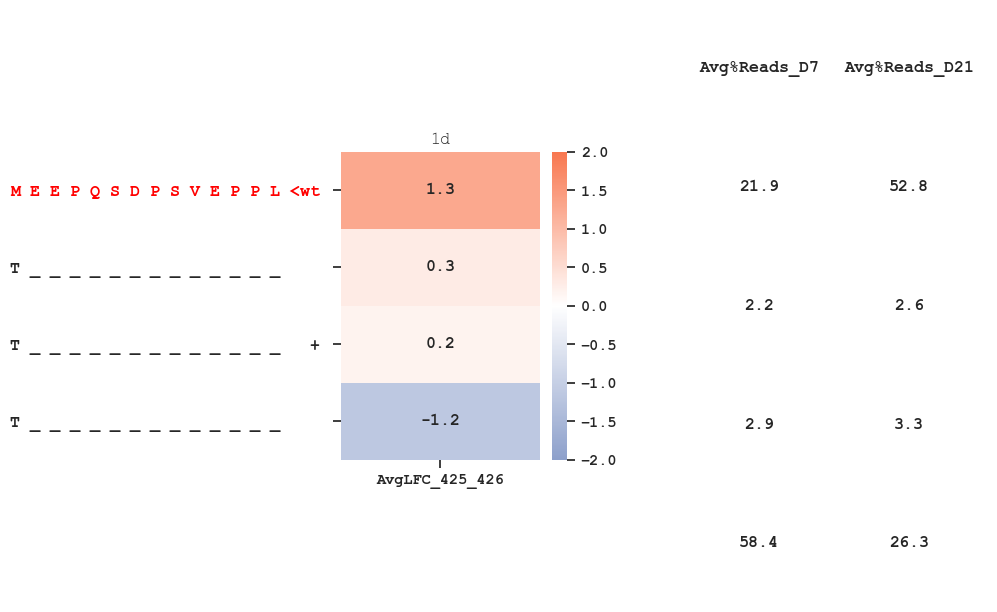

In [130]:
heatmaps(df = input_file,
         vmin = -2,
         vmax = 2,
         filepath = output_filepath,
         time1 = 'D7',
         time2 = 'D21',
         timepoint_df = timepoint_input_file,
         filename = 'TP53_ABE_heatmap_1d'
        )